# eBay Auction Price Prediction Model


This notebook demonstrates the use of machine learning models to predict the price of eBay auctions that resulted in a sale.

We will evaluate two models for price prediction:
1. **Random Forest Regressor** for regression task
2. **Linear Regression** for regression task

The dataset used is filtered to only include auctions that resulted in a sale.


In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Load the full datasets
file_path = 'raw.tar.gz'
extracted_path = '/mnt/data/raw_data/'

import tarfile
import os
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extracted_path)

raw_dir = os.path.join(extracted_path, 'raw')
training_set = pd.read_csv(os.path.join(raw_dir, 'TrainingSet.csv'))
test_set = pd.read_csv(os.path.join(raw_dir, 'TestSet.csv'))

# Target 2: Predict QuantitySold (full dataset)
train_full = training_set
test_full = test_set

# Separate numeric and categorical columns
numeric_cols = train_full.select_dtypes(include=[np.number]).columns
categorical_cols = train_full.select_dtypes(exclude=[np.number]).columns

# Check for missing values and handle them for numeric columns with median
train_full[numeric_cols] = train_full[numeric_cols].fillna(train_full[numeric_cols].median())
test_full[numeric_cols] = test_full[numeric_cols].fillna(test_full[numeric_cols].median())

# Check for missing values and handle them for categorical columns with mode
train_full[categorical_cols] = train_full[categorical_cols].fillna(train_full[categorical_cols].mode().iloc[0])
test_full[categorical_cols] = test_full[categorical_cols].fillna(test_full[categorical_cols].mode().iloc[0])

# Features for QuantitySold prediction
features_full = ['Price', 'AvgPrice', 'SellerClosePercent', 'StartingBid', 'PricePercent', 'StartingBidPercent']
X_full = train_full[features_full]
y_full = train_full['QuantitySold']
X_test_full = test_full[features_full]
y_test_full = test_full['QuantitySold']

# Scaling data
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
X_test_full_scaled = scaler.transform(X_test_full)

# Train/Test Split (80% for training, 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_full_scaled, y_full, test_size=0.2, random_state=42)


In [ ]:
# Model 1: RandomForestClassifier with Hyperparameter Tuning and Cross-Validation
rf_classifier = RandomForestClassifier(random_state=42)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# GridSearchCV to tune Random Forest
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best parameters for RandomForestClassifier:", grid_search_rf.best_params_)

# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Evaluate using cross-validation on the training set
cv_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Random Forest - Mean Accuracy (CV): {cv_scores_rf.mean():.4f}, Std Dev (CV): {cv_scores_rf.std():.4f}")

# Predictions on the validation set
y_pred_val_rf = best_rf_model.predict(X_val)
accuracy_val_rf = accuracy_score(y_val, y_pred_val_rf)
print(f"Random Forest - Validation Accuracy: {accuracy_val_rf:.4f}")

# Evaluate on the test set
y_pred_test_rf = best_rf_model.predict(X_test_full_scaled)
accuracy_test_rf = accuracy_score(y_test_full, y_pred_test_rf)
print(f"Random Forest - Test Accuracy: {accuracy_test_rf:.4f}")

# Model 2: Logistic Regression
lr_classifier = LogisticRegression(random_state=42)

# Fit Logistic Regression on training data
lr_classifier.fit(X_train, y_train)

# Predictions on the validation set for Logistic Regression
y_pred_val_lr = lr_classifier.predict(X_val)
accuracy_val_lr = accuracy_score(y_val, y_pred_val_lr)
print(f"Logistic Regression - Validation Accuracy: {accuracy_val_lr:.4f}")

# Evaluate on the test set for Logistic Regression
y_pred_test_lr = lr_classifier.predict(X_test_full_scaled)
accuracy_test_lr = accuracy_score(y_test_full, y_pred_test_lr)
print(f"Logistic Regression - Test Accuracy: {accuracy_test_lr:.4f}")

# Confusion Matrix and Classification Report for Random Forest
print("\nConfusion Matrix for Random Forest:")
print(confusion_matrix(y_test_full, y_pred_test_rf))

print("\nClassification Report for Random Forest:")
print(classification_report(y_test_full, y_pred_test_rf))

# Confusion Matrix and Classification Report for Logistic Regression
print("\nConfusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test_full, y_pred_test_lr))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test_full, y_pred_test_lr))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", 

Best parameters for RandomForestClassifier: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Mean Accuracy (CV): 0.8863, Std Dev (CV): 0.0015
Random Forest - Validation Accuracy: 0.8866
Random Forest - Test Accuracy: 0.8964
Logistic Regression - Validation Accuracy: 0.8766
Logistic Regression - Test Accuracy: 0.8892

Confusion Matrix for Random Forest:
[[27541   520]
 [ 3362  6037]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     28061
           1       0.92      0.64      0.76      9399

    accuracy                           0.90     37460
   macro avg       0.91      0.81      0.85     37460
weighted avg       0.90      0.90      0.89     37460


Confusion Matrix for Logistic Regression:
[[27530   531]
 [ 3618  5781]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   

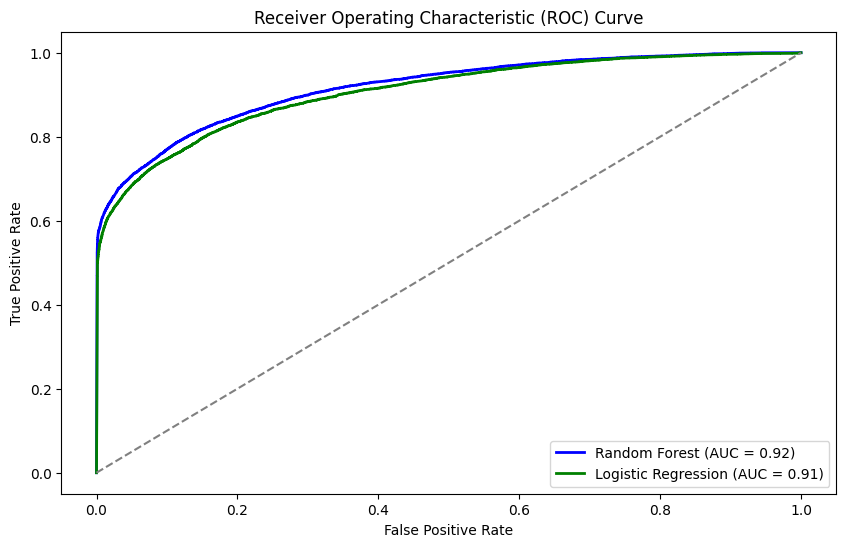

In [ ]:
# ROC Curve and AUC for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test_full, best_rf_model.predict_proba(X_test_full_scaled)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test_full, lr_classifier.predict_proba(X_test_full_scaled)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC Curve for both models
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# prompt: how many records per distinct values of test_full['QuantitySold']

print(test_full.groupby('QuantitySold').size())

QuantitySold
0    28061
1     9399
dtype: int64


In [ ]:
# Model 1: RandomForestClassifier with Hyperparameter Tuning and Cross-Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize RandomForestClassifier with class weight='balanced'
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV to tune Random Forest
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best parameters for RandomForestClassifier:", grid_search_rf.best_params_)

# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Evaluate using cross-validation on the training set
cv_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Random Forest - Mean Accuracy (CV): {cv_scores_rf.mean():.4f}, Std Dev (CV): {cv_scores_rf.std():.4f}")

# Predictions on the validation set
y_pred_val_rf = best_rf_model.predict(X_val)
accuracy_val_rf = accuracy_score(y_val, y_pred_val_rf)
print(f"Random Forest - Validation Accuracy: {accuracy_val_rf:.4f}")

# Evaluate on the test set
y_pred_test_rf = best_rf_model.predict(X_test_full_scaled)
accuracy_test_rf = accuracy_score(y_test_full, y_pred_test_rf)
print(f"Random Forest - Test Accuracy: {accuracy_test_rf:.4f}")


# Model 2: Logistic Regression with class weights
from sklearn.linear_model import LogisticRegression

# Initialize LogisticRegression with class_weight='balanced'
lr_classifier = LogisticRegression(random_state=42, class_weight='balanced')

# Fit Logistic Regression on training data
lr_classifier.fit(X_train, y_train)

# Predictions on the validation set for Logistic Regression
y_pred_val_lr = lr_classifier.predict(X_val)
accuracy_val_lr = accuracy_score(y_val, y_pred_val_lr)
print(f"Logistic Regression - Validation Accuracy: {accuracy_val_lr:.4f}")

# Evaluate on the test set for Logistic Regression
y_pred_test_lr = lr_classifier.predict(X_test_full_scaled)
accuracy_test_lr = accuracy_score(y_test_full, y_pred_test_lr)
print(f"Logistic Regression - Test Accuracy: {accuracy_test_lr:.4f}")

# Confusion Matrix and Classification Report for Random Forest
print("\nConfusion Matrix for Random Forest:")
print(confusion_matrix(y_test_full, y_pred_test_rf))

print("\nClassification Report for Random Forest:")
print(classification_report(y_test_full, y_pred_test_rf))

# Confusion Matrix and Classification Report for Logistic Regression
print("\nConfusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test_full, y_pred_test_lr))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test_full, y_pred_test_lr))


Best parameters for RandomForestClassifier: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Mean Accuracy (CV): 0.8766, Std Dev (CV): 0.0015
Random Forest - Validation Accuracy: 0.8780
Random Forest - Test Accuracy: 0.8868
Logistic Regression - Validation Accuracy: 0.8589
Logistic Regression - Test Accuracy: 0.8747

Confusion Matrix for Random Forest:
[[26634  1427]
 [ 2812  6587]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     28061
           1       0.82      0.70      0.76      9399

    accuracy                           0.89     37460
   macro avg       0.86      0.82      0.84     37460
weighted avg       0.88      0.89      0.88     37460


Confusion Matrix for Logistic Regression:
[[26036  2025]
 [ 2669  6730]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   